In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import time
import pickle

In [2]:
df = pd.read_csv('green_trip_data_2018-9clean.csv')

In [3]:
df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
lpep_pickup_datetime,2018-09-01 00:52:38,2018-09-01 00:32:40,2018-09-01 00:07:55,2018-09-01 00:53:25,2018-09-01 00:14:33
lpep_dropoff_datetime,2018-09-01 01:05:00,2018-09-01 00:47:18,2018-09-01 00:15:19,2018-09-01 00:58:03,2018-09-01 00:30:57
pu_location,160,180,71,79,64
do_location,205,186,75,100,100
passenger_count,1.0,5.0,1.0,1.0,2.0
trip_distance,5.47,3.47,1.9,0.69,3.83
fare_amount,17.0,13.5,8.5,5.0,14.5
extra,0.5,0.5,0.5,0.5,0.5
mta_tax,0.5,0.5,0.5,0.5,0.5


In [4]:
def extract_coordinates(coord_str):
    coord_str = coord_str.strip('()')
    x, y = map(float, coord_str.split(', '))
    return x, y

df['pickup_location_coordinates_x'], df['pickup_location_coordinates_y'] = zip(*df['pickup_location_coordinates'].apply(extract_coordinates))
df['dropoff_location_coordinates_x'], df['dropoff_location_coordinates_y'] = zip(*df['dropoff_location_coordinates'].apply(extract_coordinates))

df.drop(columns=['pickup_location_coordinates', 'dropoff_location_coordinates'], inplace=True)

Extracting the x and y coordinates from the 'pickup_location_coordinates' and 'dropoff_location_coordinates' into 4 new columns.

In [5]:
cols = ['Unnamed: 0', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'pickup_location_coordinates_missing', 'dropoff_location_coordinates_missing']
df = df.drop(cols, axis=1)

In [6]:
df = pd.get_dummies(df)

One hot encoding for the date_range

In [7]:
df['trip_price'] = pd.cut(df['total_amount'], bins=3, labels=['low', 'medium', 'high'])
cols = ['total_amount']
df = df.drop(cols, axis=1)

In [8]:
df.head().T

,0,1,2,3,4
pu_location,160,180,71,79,64
do_location,205,186,75,100,100
passenger_count,1.0,5.0,1.0,1.0,2.0
trip_distance,5.47,3.47,1.9,0.69,3.83
fare_amount,17.0,13.5,8.5,5.0,14.5
extra,0.5,0.5,0.5,0.5,0.5
mta_tax,0.5,0.5,0.5,0.5,0.5
tip_amount,0.0,0.0,0.0,0.0,1.0
tolls_amount,0.0,0.0,0.0,0.0,0.0
improvement_surcharge,0.3,0.3,0.3,0.3,0.3


Discretizing the trip price into low, medium, and high

In [9]:
le = LabelEncoder()
df['trip_price'] = le.fit_transform(df['trip_price'])

In [10]:
df.head().T

,0,1,2,3,4
pu_location,160,180,71,79,64
do_location,205,186,75,100,100
passenger_count,1.0,5.0,1.0,1.0,2.0
trip_distance,5.47,3.47,1.9,0.69,3.83
fare_amount,17.0,13.5,8.5,5.0,14.5
extra,0.5,0.5,0.5,0.5,0.5
mta_tax,0.5,0.5,0.5,0.5,0.5
tip_amount,0.0,0.0,0.0,0.0,1.0
tolls_amount,0.0,0.0,0.0,0.0,0.0
improvement_surcharge,0.3,0.3,0.3,0.3,0.3


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681899 entries, 0 to 681898
Data columns (total 44 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   pu_location                               681899 non-null  int64  
 1   do_location                               681899 non-null  int64  
 2   passenger_count                           681899 non-null  float64
 3   trip_distance                             681899 non-null  float64
 4   fare_amount                               681899 non-null  float64
 5   extra                                     681899 non-null  float64
 6   mta_tax                                   681899 non-null  float64
 7   tip_amount                                681899 non-null  float64
 8   tolls_amount                              681899 non-null  float64
 9   improvement_surcharge                     681899 non-null  float64
 10  week_number         

In [12]:
df.to_csv('cleaned.csv')

In [13]:
df = pd.read_csv('cleaned.csv')

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

- Splits the DataFrame into input features (X) and the target variable (y:trip_price).
- Divides the data into training and testing sets using an 80/20 split
- Standardizes the features to have a mean of 0 and a standard deviation of 1, which improves the performance of many machine learning algorithms.

Loaded the dataset into df after discretizing the trip_price into 3 categories 0: high, 1: low, and 2: medium. Split the dataset into the input X which contains all columns but the last one 'trip_price' which is the output y. Then split the X and y into train and test sets. And finally, normalized the dataset.

In [14]:
df['trip_price'].value_counts()

trip_price
1    436326
2    123276
0    122297
Name: count, dtype: int64

The first step in preprocessing the data, beyond the initial cleaning (data engineering), is to prepare it for supervised learning by ensuring it is properly labeled. Therefore, we removed the feature representing the total trip amount and replaced it with a categorical label: high, medium, or low. This serves two purposes. First, it provides the necessary labeled data for supervised learning. Second, it helps prevent overfitting, where the model might otherwise overlearn the data to the point of memorization. We now proceed to implement our six classification models, incorporating techniques of diagnostics such as resampling and regularization.

## Classification

In [15]:
train_accuracies = []
test_accuracies = []
train_time = []
prediction_time = []
models = ['KNN', 'Logistic Regression', 'Decision Trees', 'Random Forest', 'Naive Bayes']

These are for comparing all models after training them.

### KNN

In [16]:
knn = KNeighborsClassifier()

optimal_k = round(np.sqrt(X_train.shape[0])/2)
optimal_k2 = round(np.sqrt(X_train.shape[0]))

n_neighbors = list(np.arange(2,20,1))
n_neighbors.append(optimal_k)
n_neighbors.append(optimal_k2)
p = [1,2]

params = {
    'n_neighbors': n_neighbors,
    'p': p
}

knn_gscv = GridSearchCV(estimator=knn, param_grid=params, cv=3, verbose=3)
knn_gscv.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3] END ................n_neighbors=2, p=1;, score=0.941 total time= 7.9min
[CV 2/3] END ................n_neighbors=2, p=1;, score=0.942 total time= 8.0min
[CV 3/3] END ................n_neighbors=2, p=1;, score=0.941 total time= 8.0min
[CV 1/3] END ................n_neighbors=2, p=2;, score=0.935 total time= 2.5min
[CV 2/3] END ................n_neighbors=2, p=2;, score=0.935 total time= 2.5min
[CV 3/3] END ................n_neighbors=2, p=2;, score=0.935 total time= 2.6min
[CV 1/3] END ................n_neighbors=3, p=1;, score=0.954 total time= 7.9min
[CV 2/3] END ................n_neighbors=3, p=1;, score=0.955 total time= 7.9min
[CV 3/3] END ................n_neighbors=3, p=1;, score=0.954 total time= 8.0min
[CV 1/3] END ................n_neighbors=3, p=2;, score=0.946 total time= 2.6min
[CV 2/3] END ................n_neighbors=3, p=2;, score=0.946 total time= 2.6min
[CV 3/3] END ................n_neighbors=3, p=2

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 369, 739],
                         'p': [1, 2]},
             verbose=3)

In [17]:
optimal_k, optimal_k2

(369, 739)

For the KNN and all the other models, we used GridSearchCV which is a scikit-learn tool that takes as parameters the model (estimator) and all of the parameters of the model that we want to use (param_grid), then train the data using these parameters with each other so because we tried 2 parameteres 'n_neighbors' and 'p' with 20 and 2 values respectively, it will train the model 40 times with different combinations of parameters. Furthermore, we specified the cv to be equal to 3 which means that for each iteration the model will split the data into 3 sets, one will be used for testing and the other 2 for training. Then the second will be used for testing and then the third will be used for testing while training with the other 2. So for each combination of parameters, there will be 3 trainings which means the total models trained will be equal to 120. For each iteration, a score will be calculated and for each model combination of parameters the score will be the average of the three models trained. we tried different values for the 'n_neighbors' parameter ranging from 2 to 20 as well as 369 and 739 as we found that sometimes the optimal values for this parameter might be the sqaure root of the number of samples and half the square root of the number of samples. we tried all these values twice, each time for a different distance metric specified by the 'p' parameter which indicates the euclidean or manhattan distances.

In [18]:
pickle.dump(knn_gscv, open('knn_gscv.pkl', 'wb'))

Due to the models taking so much time to run we Save the model into a pickle file so that we don't need to train it again if the kernel was shut down & to speed up the process of not needing to train the model each time we work on the project.

In [16]:
knn_gscv = pickle.load(open('knn_gscv.pkl', 'rb'))

c:\anacon\envs\data_eng\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\anacon\envs\data_eng\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [17]:
knn_gscv.best_estimator_, knn_gscv.best_params_, knn_gscv.best_score_

(KNeighborsClassifier(n_neighbors=7, p=1),
 {'n_neighbors': 7, 'p': 1},
 0.9573452058145634)

we can then access the GridSearchCV attributes which can tell the best model, parameters, and score. Which can then be used to train on the full training data and tested on the test data.

In [18]:
train_time.append(knn_gscv.refit_time_)

In [19]:
train_accuracies.append(knn_gscv.best_score_)

In [20]:
t_start = time.time()
y_preds = knn_gscv.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time.append(total_time)

c:\anacon\envs\data_eng\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\anacon\envs\data_eng\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


In [16]:
pred_score = accuracy_score(y_test, y_preds)
test_accuracies.append(pred_score)

Appending the results into the lists we initiated at the start for later comparisons.

In [19]:
knn_cv_results = knn_gscv.cv_results_
knn_cv_results['mean_test_score']

array([0.94119362, 0.93490969, 0.95435356, 0.94583323, 0.95118777,
       0.94263078, 0.95635716, 0.94702659, 0.95418125, 0.94473336,
       0.95734521, 0.94715491, 0.9554021 , 0.94515315, 0.95727371,
       0.94690011, 0.95567157, 0.94513665, 0.95726455, 0.94611737,
       0.95580172, 0.94494234, 0.95688326, 0.94555826, 0.95555792,
       0.94448223, 0.95657346, 0.945012  , 0.95536911, 0.94410277,
       0.95620684, 0.94452989, 0.9551143 , 0.94361516, 0.95570457,
       0.94387546, 0.92330606, 0.90012813, 0.90967317, 0.881544  ])

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    knn_gscv.best_estimator_, X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (KNN)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.7, 1.01)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

Unfortunately, KNN takes too long to make predictions so running this cell and outputting the learning curve will take too much time. However, all other models will have learning curve graphs.

In [24]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     24373
           1       0.97      0.99      0.98     87290
           2       0.91      0.87      0.89     24717

    accuracy                           0.96    136380
   macro avg       0.95      0.94      0.94    136380
weighted avg       0.96      0.96      0.96    136380



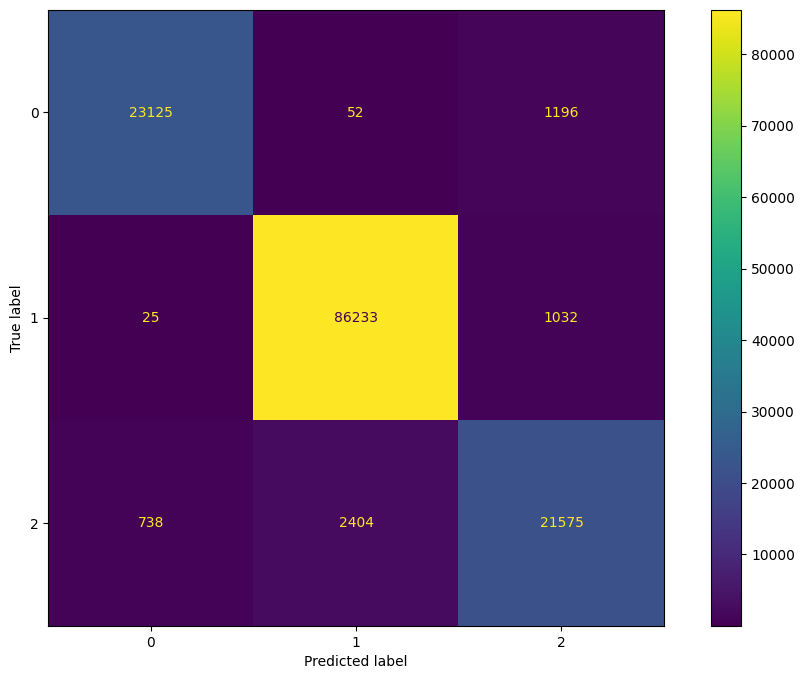

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

## Logistic Regression

In [26]:
lr = LogisticRegression()

params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 500, 1000]
}

lr_gscv = GridSearchCV(estimator=lr, param_grid=params, cv=3, verbose=3)
lr_gscv.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END .............C=0.001, max_iter=100;, score=0.970 total time=   4.0s
[CV 2/3] END .............C=0.001, max_iter=100;, score=0.970 total time=   3.6s
[CV 3/3] END .............C=0.001, max_iter=100;, score=0.970 total time=   3.8s
[CV 1/3] END .............C=0.001, max_iter=500;, score=0.970 total time=   3.9s
[CV 2/3] END .............C=0.001, max_iter=500;, score=0.970 total time=   3.4s
[CV 3/3] END .............C=0.001, max_iter=500;, score=0.970 total time=   3.6s
[CV 1/3] END ............C=0.001, max_iter=1000;, score=0.970 total time=   3.6s
[CV 2/3] END ............C=0.001, max_iter=1000;, score=0.970 total time=   3.3s
[CV 3/3] END ............C=0.001, max_iter=1000;, score=0.970 total time=   3.6s
[CV 1/3] END ..............C=0.01, max_iter=100;, score=0.984 total time=   5.6s
[CV 2/3] END ..............C=0.01, max_iter=100;, score=0.984 total time=   5.2s
[CV 3/3] END ..............C=0.01, max_iter=100;

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 500, 1000]},
             verbose=3)

Again, GridSearchCV is used to get the best decision tree model using the parameters specified in the 'params' dictionary.

In [27]:
pickle.dump(lr_gscv, open('lr_gscv.pkl', 'wb'))

Saving the model into a pickle file so that we don't need to train it again if the kernel was shut down.

In [3]:
lr_gscv = pickle.load(open('lr_gscv.pkl', 'rb'))

In [21]:
lr_gscv.best_estimator_, lr_gscv.best_params_, lr_gscv.best_score_

(LogisticRegression(C=100), {'C': 100, 'max_iter': 100}, 0.9913018609180438)

Best model, parameters, and score

In [22]:
train_time.append(lr_gscv.refit_time_)

In [23]:
train_accuracies.append(lr_gscv.best_score_)

In [24]:
t_start = time.time()
y_preds = lr_gscv.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time.append(total_time)

In [25]:
pred_score = accuracy_score(y_test, y_preds)
test_accuracies.append(pred_score)

In [43]:
lr_cv_results = lr_gscv.cv_results_
lr_cv_results['mean_test_score']

array([0.97009637, 0.97009637, 0.97009637, 0.9835936 , 0.9835936 ,
       0.9835936 , 0.98940825, 0.98940825, 0.98940825, 0.99109838,
       0.99109838, 0.99109838, 0.99121937, 0.99121937, 0.99121937,
       0.99130186, 0.99130186, 0.99130186])

Appending the results into the lists I initiated at the start for later comparisons.

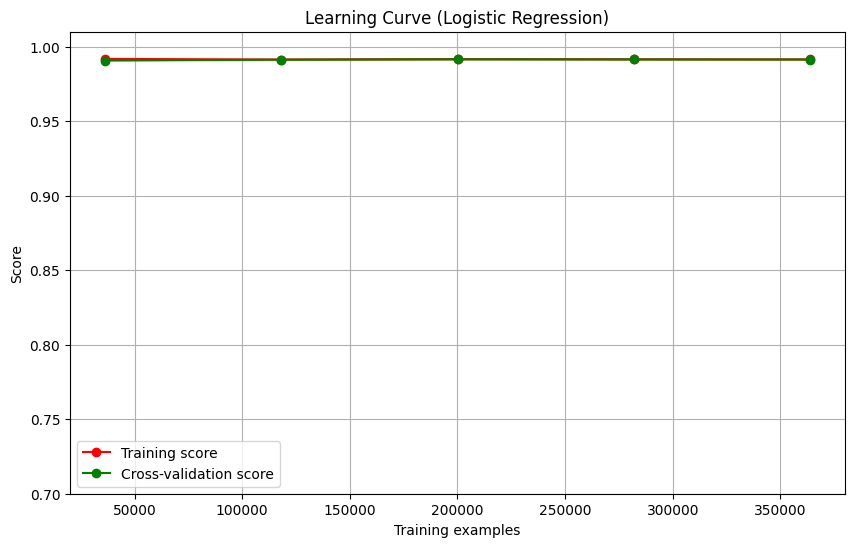

In [6]:
train_sizes, train_scores, test_scores = learning_curve(
    lr_gscv.best_estimator_, X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (Logistic Regression)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.7, 1.01)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [33]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     24373
           1       1.00      1.00      1.00     87290
           2       0.98      0.98      0.98     24717

    accuracy                           0.99    136380
   macro avg       0.99      0.99      0.99    136380
weighted avg       0.99      0.99      0.99    136380



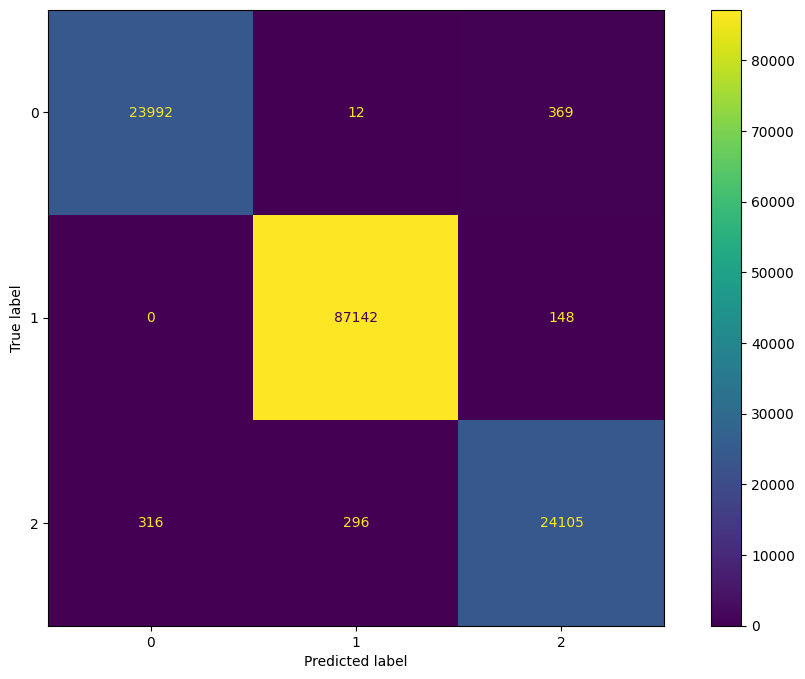

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

## Decision Trees

In [35]:
dt = DecisionTreeClassifier()

params = {
    'max_depth': [None, 2, 4, 8, 10],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

dt_gscv = GridSearchCV(estimator=dt, param_grid=params, cv=3, verbose=3)
dt_gscv.fit(X_train, y_train)

Fitting 3 folds for each of 160 candidates, totalling 480 fits
[CV 1/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.995 total time=   8.6s
[CV 2/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.995 total time=   8.6s
[CV 3/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.994 total time=   8.5s
[CV 1/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=4;, score=0.995 total time=   8.5s
[CV 2/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=4;, score=0.995 total time=   8.6s
[CV 3/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=4;, score=0.995 total time=   8.4s
[CV 1/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6;, score=0.995 total time=   8.7s
[CV 2/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6;, score=0.995 total time= 

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 4, 8, 10],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 6, 8]},
             verbose=3)

Again, GridSearchCV is used to get the best decision tree model using the parameters specified in the 'params' dictionary.

In [36]:
pickle.dump(dt_gscv, open('dt_gscv.pkl', 'wb'))

Saving the model into a pickle file so that we don't need to train it again if the kernel was shut down.

In [7]:
dt_gscv = pickle.load(open('dt_gscv.pkl', 'rb'))

In [28]:
dt_gscv.best_estimator_, dt_gscv.best_params_, dt_gscv.best_score_

(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2,
                        min_samples_split=4),
 {'criterion': 'entropy',
  'max_depth': None,
  'min_samples_leaf': 2,
  'min_samples_split': 4},
 0.9961449549933556)

Best model, parameters, and score

In [29]:
train_time.append(dt_gscv.refit_time_)

In [30]:
train_accuracies.append(dt_gscv.best_score_)

In [31]:
t_start = time.time()
y_preds = dt_gscv.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time.append(total_time)

In [32]:
pred_score = accuracy_score(y_test, y_preds)
test_accuracies.append(pred_score)

In [42]:
dt_cv_results = dt_gscv.cv_results_
dt_cv_results['mean_test_score']

array([0.99481411, 0.99482328, 0.99487277, 0.99504875, 0.99510191,
       0.99516607, 0.99516607, 0.99526689, 0.99543737, 0.99541171,
       0.99547403, 0.99540804, 0.99526873, 0.99526139, 0.99525223,
       0.99529806, 0.94796332, 0.94796332, 0.94796332, 0.94796332,
       0.94796332, 0.94796332, 0.94796332, 0.94796332, 0.94796332,
       0.94796332, 0.94796332, 0.94796332, 0.94796332, 0.94796332,
       0.94796332, 0.94796332, 0.9796579 , 0.9796579 , 0.9796579 ,
       0.9796579 , 0.9796579 , 0.9796579 , 0.9796579 , 0.9796579 ,
       0.9796579 , 0.9796579 , 0.9796579 , 0.9796579 , 0.9796579 ,
       0.9796579 , 0.9796579 , 0.9796579 , 0.99368491, 0.99368675,
       0.99368491, 0.99369591, 0.99367758, 0.99367208, 0.99366842,
       0.99367941, 0.99368491, 0.99368491, 0.99368675, 0.99367941,
       0.99362809, 0.99362442, 0.99362809, 0.99363175, 0.99453731,
       0.99454281, 0.99454648, 0.99456481, 0.99456664, 0.99458681,
       0.99455931, 0.99455931, 0.99457764, 0.99458497, 0.99455

Appending the results into the lists I initiated at the start for later comparisons.

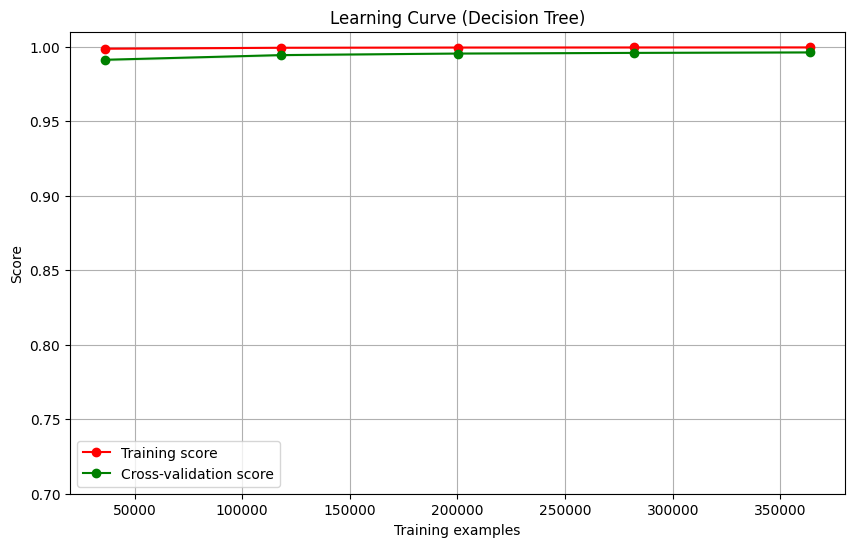

In [8]:
train_sizes, train_scores, test_scores = learning_curve(
    dt_gscv.best_estimator_, X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (Decision Tree)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.7, 1.01)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [42]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     24373
           1       1.00      1.00      1.00     87290
           2       0.99      0.99      0.99     24717

    accuracy                           1.00    136380
   macro avg       1.00      0.99      0.99    136380
weighted avg       1.00      1.00      1.00    136380



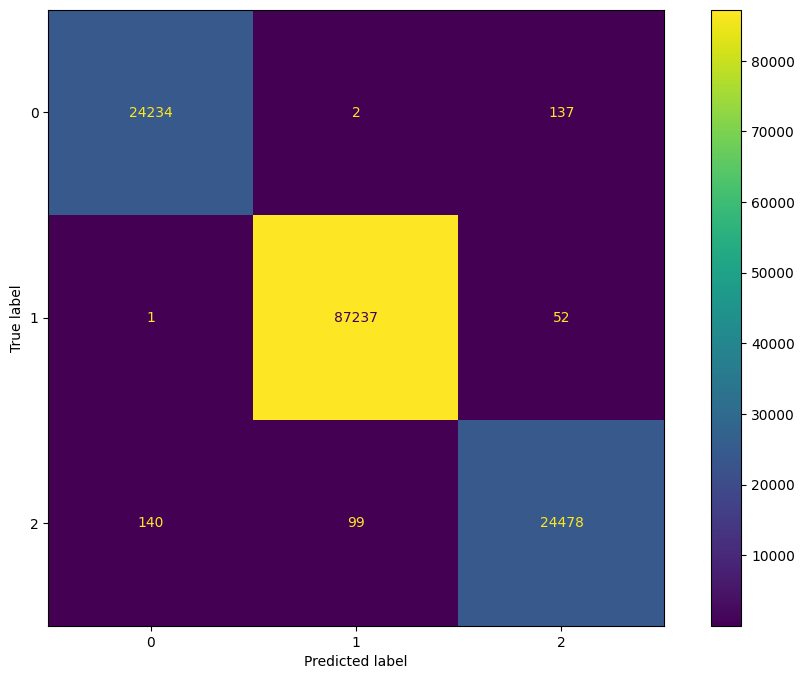

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

## Random Forest

In [44]:
rf = RandomForestClassifier()

params = {
    'n_estimators': [2, 4, 8, 16, 32, 100, 200],
    'max_depth': [None, 2],
    'min_samples_split': [6, 8],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

rf_gscv = GridSearchCV(estimator=rf, param_grid=params, cv=3, verbose=3)
rf_gscv.fit(X_train, y_train)

Fitting 3 folds for each of 168 candidates, totalling 504 fits
[CV 1/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=2;, score=0.984 total time=   2.1s
[CV 2/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=2;, score=0.980 total time=   2.1s
[CV 3/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=2;, score=0.983 total time=   1.9s
[CV 1/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=4;, score=0.990 total time=   4.1s
[CV 2/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=4;, score=0.989 total time=   4.6s
[CV 3/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=4;, score=0.990 total time=   4.2s
[CV 1/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=8;, score=0.992 total time=   8.4s

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [6, 8],
                         'n_estimators': [2, 4, 8, 16, 32, 100, 200]},
             verbose=3)

GridSearchCV is used to get the best random forest model using the parameters specified in the 'params' dictionary.

In [45]:
pickle.dump(rf_gscv, open('rf_gscv.pkl', 'wb'))

Saving the model into a pickle file so that we don't need to train it again if the kernel was shut down.

In [9]:
rf_gscv = pickle.load(open('rf_gscv.pkl', 'rb'))

In [36]:
rf_gscv.best_estimator_, rf_gscv.best_params_, rf_gscv.best_score_

(RandomForestClassifier(criterion='entropy', min_samples_split=6,
                        n_estimators=200),
 {'criterion': 'entropy',
  'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 200},
 0.9947242899519946)

Best model, parameters, and score

In [37]:
train_time.append(rf_gscv.refit_time_)

In [38]:
train_accuracies.append(rf_gscv.best_score_)

In [39]:
t_start = time.time()
y_preds = rf_gscv.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time.append(total_time)

In [40]:
pred_score = accuracy_score(y_test, y_preds)
test_accuracies.append(pred_score)

In [41]:
rf_cv_results = rf_gscv.cv_results_
rf_cv_results['mean_test_score']

array([0.98236542, 0.98965022, 0.99290584, 0.99371058, 0.994321  ,
       0.99455014, 0.9946253 , 0.98096309, 0.99006451, 0.99253188,
       0.99358226, 0.99413769, 0.99452265, 0.99453731, 0.98300151,
       0.98956223, 0.99249889, 0.99343561, 0.99410836, 0.99435033,
       0.99444566, 0.98394373, 0.99036331, 0.99243106, 0.99342461,
       0.99394888, 0.99425318, 0.99443099, 0.98610314, 0.99003151,
       0.99239806, 0.99301033, 0.99382423, 0.99397455, 0.99412303,
       0.98291718, 0.98914245, 0.99156033, 0.99322847, 0.99366108,
       0.9940552 , 0.99405704, 0.80318384, 0.86276196, 0.79159109,
       0.89096994, 0.88578588, 0.90054059, 0.88884895, 0.86453458,
       0.81413845, 0.88892585, 0.90625992, 0.85135623, 0.87403009,
       0.87370743, 0.76709708, 0.77347642, 0.80091633, 0.86453264,
       0.88172549, 0.89018897, 0.88664738, 0.84714558, 0.74784937,
       0.83608281, 0.88158621, 0.87016584, 0.8776853 , 0.87551857,
       0.77067873, 0.86510638, 0.81221354, 0.85861166, 0.86809

Appending the results into the lists I initiated at the start for later comparisons.

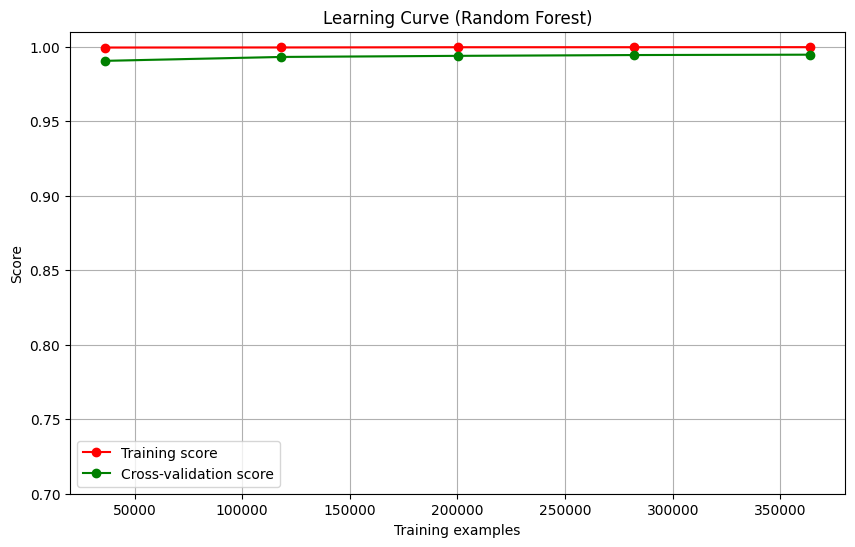

In [10]:
train_sizes, train_scores, test_scores = learning_curve(
    rf_gscv.best_estimator_, X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (Random Forest)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.7, 1.01)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [51]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     24373
           1       1.00      1.00      1.00     87290
           2       0.99      0.99      0.99     24717

    accuracy                           1.00    136380
   macro avg       0.99      0.99      0.99    136380
weighted avg       1.00      1.00      1.00    136380



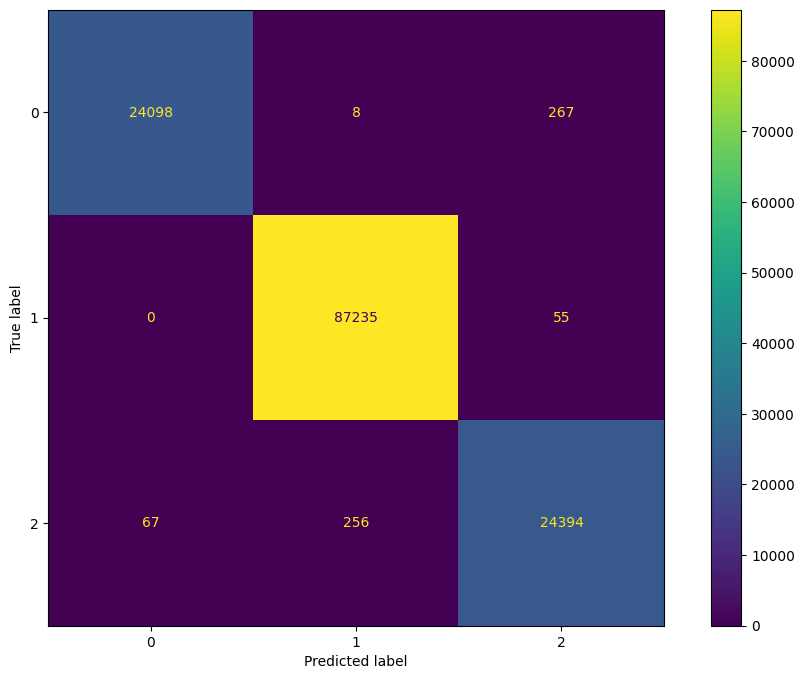

In [52]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

## Naive Bayes

In [53]:
nb = GaussianNB()

params = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nb_gscv = GridSearchCV(estimator=nb, param_grid=params, cv=3, verbose=3, n_jobs=-1)
nb_gscv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=3)

The GridSearchCV doesn't output anything using the GaussianNB classifier however the trainig time didn't take long and it outputted the needed results. One reason for not outputting anything I found is that there is no parameter tuning for the GaussianNB.

'var_smoothing' is a stability calculation to widen (or smooth) the curve and therefore account for more samples that are further away from the distribution mean. 

In [54]:
pickle.dump(nb_gscv, open('nb_gscv.pkl', 'wb'))

Saving the model into a pickle file so that we don't need to train it again if the kernel was shut down.

In [11]:
nb_gscv = pickle.load(open('nb_gscv.pkl', 'rb'))

In [45]:
nb_gscv.best_estimator_, nb_gscv.best_params_, nb_gscv.best_score_

(GaussianNB(var_smoothing=0.0001873817422860383),
 {'var_smoothing': 0.0001873817422860383},
 0.8283946006192631)

Best model, parameters, and score

In [46]:
train_time.append(nb_gscv.refit_time_)

In [47]:
train_accuracies.append(nb_gscv.best_score_)

In [48]:
t_start = time.time()
y_preds = nb_gscv.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time.append(total_time)

In [49]:
pred_score = accuracy_score(y_test, y_preds)
test_accuracies.append(pred_score)

In [50]:
nb_cv_results = nb_gscv.cv_results_
nb_cv_results['mean_test_score']

array([0.70862243, 0.71678347, 0.72533862, 0.73379845, 0.74220879,
       0.75102058, 0.75938692, 0.76698886, 0.77401519, 0.78075922,
       0.7866307 , 0.79156728, 0.79624173, 0.79998862, 0.80310308,
       0.8057831 , 0.80775553, 0.80946399, 0.81086083, 0.81197169,
       0.81291025, 0.81366916, 0.81432175, 0.81500184, 0.81568009,
       0.81641334, 0.81706776, 0.81791832, 0.81884405, 0.81972761,
       0.82066983, 0.82166338, 0.82280358, 0.82383013, 0.82468803,
       0.82554226, 0.82635067, 0.82721223, 0.827808  , 0.82821862,
       0.82834144, 0.8283946 , 0.8281508 , 0.82776585, 0.82697578,
       0.82608855, 0.82492453, 0.82349103, 0.82178441, 0.81988164,
       0.81790371, 0.81563982, 0.8130203 , 0.81025046, 0.80737064,
       0.80422318, 0.80076776, 0.79689989, 0.79307785, 0.7889955 ,
       0.78465469, 0.77996375, 0.77544696, 0.77037839, 0.76512469,
       0.75960518, 0.75383087, 0.74783841, 0.74144451, 0.73492045,
       0.7281141 , 0.72101811, 0.71364899, 0.70592791, 0.69786

Appending the results into the lists I initiated at the start for later comparisons.

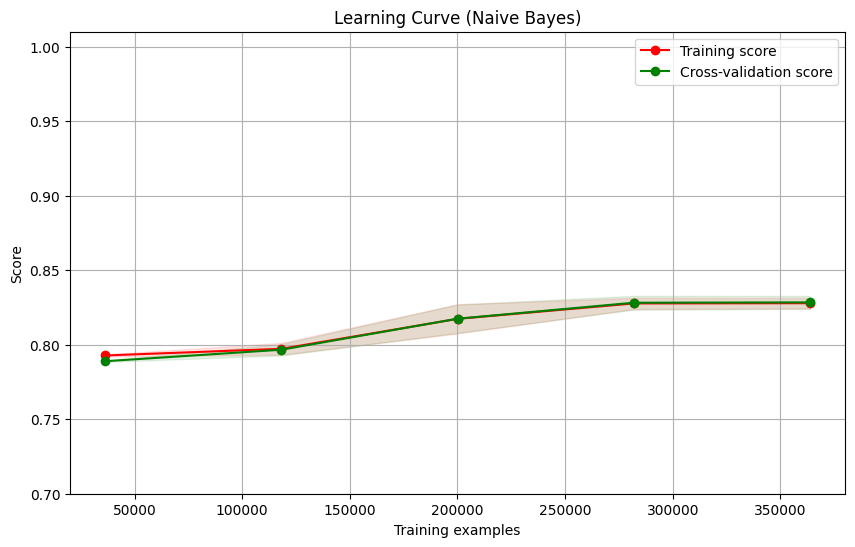

In [12]:
train_sizes, train_scores, test_scores = learning_curve(
    nb_gscv.best_estimator_, X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (Naive Bayes)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.7, 1.01)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [60]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.41      0.55     24373
           1       0.99      0.92      0.95     87290
           2       0.52      0.91      0.66     24717

    accuracy                           0.83    136380
   macro avg       0.78      0.75      0.72    136380
weighted avg       0.88      0.83      0.83    136380



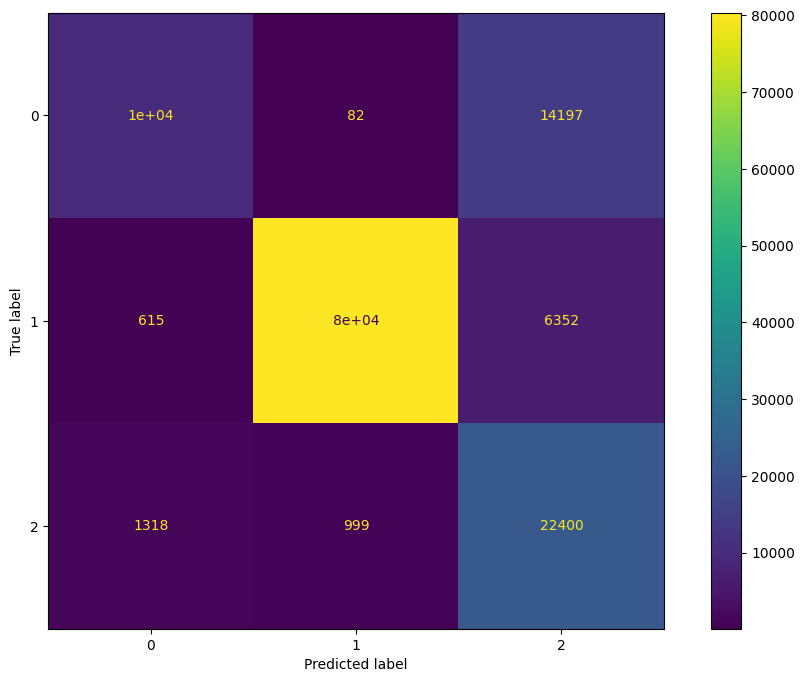

In [61]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

# Comparison

In [51]:
data_dict = {'train_accuracies': train_accuracies, 'test_accuracies': test_accuracies, 'train_time (sec)': train_time, 'prediction_time (sec)': prediction_time}
compare_df = pd.DataFrame({col: np.nan for col in data_dict.keys()}, index=models)

for col, data in data_dict.items():
    compare_df.loc[compare_df.index[:len(data)], col] = data


In [52]:
compare_df

,train_accuracies,test_accuracies,train_time (sec),prediction_time (sec)
KNN,0.957345,0.960060,0.152227,767.253599
Logistic Regression,0.991302,0.991634,8.737298,0.034194
Decision Trees,0.996145,0.996840,10.686125,0.037731
Random Forest,0.994724,0.995212,317.445117,4.796870
Naive Bayes,0.828395,0.827225,0.377641,0.359181


First, we need to compare the training and testing accuracies. Achieving similar accuracies in both indicates that our model has the ideal balance of variance and bias—neither underfitting due to high bias nor overfitting due to high variance. Overall, logistic regression, decision trees, and random forest demonstrated superior performance, each achieving over 99% accuracy during training and testing. In contrast, Naive Bayes showed the lowest accuracy, trailing KNN by approximately 14%, with an accuracy of 96%. Among the top three models, the differences in accuracy were minimal: decision trees outperformed random forest by ~0.1% and logistic regression by ~0.5%.

Furthermore, decision trees had the second shortest training time among these models and the fourth shortest overall. They also had the second lowest prediction time, just ~0.003 seconds longer than logistic regression. Therefore, decision trees appear to be the best option for this dataset.

However, given the very high accuracies, we considered that our dataset might be overly detailed. To test this, we decided to implement all models again after excluding and dropping any features related to amount. The assumpsion was that the models might be gaining extra insights from these monetary features, which, although advantageous, could mask the true performance of the models. This "dsiregarding" of data greatly highlights the importance and power of data. When such data is available, it should generally be used to one's advantage. Nevertheless, we chose to drop these features to test the robustness and strength of our models. This will help us ensure that our models are genuinely strong and not just benefitting from overly informative features.

# Preparing our "dropped" data

df['trip_price'] = pd.cut(df['total_amount'], bins=3, labels=['low', 'medium', 'high'])
cols = ['total_amount','fare_amount','extra','tip_amount','tolls_amount']
df = df.drop(cols, axis=1)


In [15]:
df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
pu_location,160,180,71,79,64
do_location,205,186,75,100,100
passenger_count,1.0,5.0,1.0,1.0,2.0
trip_distance,5.47,3.47,1.9,0.69,3.83
fare_amount,17.0,13.5,8.5,5.0,14.5
extra,0.5,0.5,0.5,0.5,0.5
mta_tax,0.5,0.5,0.5,0.5,0.5
tip_amount,0.0,0.0,0.0,0.0,1.0
tolls_amount,0.0,0.0,0.0,0.0,0.0


Discretizing the trip price into low, medium, and high

In [16]:
le = LabelEncoder()
df['trip_price'] = le.fit_transform(df['trip_price'])

In [17]:
df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
pu_location,160,180,71,79,64
do_location,205,186,75,100,100
passenger_count,1.0,5.0,1.0,1.0,2.0
trip_distance,5.47,3.47,1.9,0.69,3.83
fare_amount,17.0,13.5,8.5,5.0,14.5
extra,0.5,0.5,0.5,0.5,0.5
mta_tax,0.5,0.5,0.5,0.5,0.5
tip_amount,0.0,0.0,0.0,0.0,1.0
tolls_amount,0.0,0.0,0.0,0.0,0.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681899 entries, 0 to 681898
Data columns (total 45 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Unnamed: 0                                681899 non-null  int64  
 1   pu_location                               681899 non-null  int64  
 2   do_location                               681899 non-null  int64  
 3   passenger_count                           681899 non-null  float64
 4   trip_distance                             681899 non-null  float64
 5   fare_amount                               681899 non-null  float64
 6   extra                                     681899 non-null  float64
 7   mta_tax                                   681899 non-null  float64
 8   tip_amount                                681899 non-null  float64
 9   tolls_amount                              681899 non-null  float64
 10  improvement_surcharg

In [19]:
df = pd.read_csv('cleaned_dropped.csv')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

- Splits the DataFrame into input features (X) and the target variable (y:trip_price).
- Divides the data into training and testing sets using an 80/20 split
- Standardizes the features to have a mean of 0 and a standard deviation of 1, which improves the performance of many machine learning algorithms.

In [20]:
df['trip_price'].value_counts()
#To understand the distribution of the classes in the dataset

trip_price
1    436326
2    123276
0    122297
Name: count, dtype: int64

## Classification for dropped data

In [21]:
train_accuracies_dropped = []
test_accuracies_dropped = []
train_time_dropped = []
prediction_time_dropped = []
models_dropped = ['Logistic Regression', 'Decision Trees', 'Random Forest', 'Naive Bayes','KNN']
#KNN last as its the longest time consumer 

## Logistic Regression

In [16]:
lr = LogisticRegression()

params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 500, 1000]
}

lr_gscv_drop = GridSearchCV(estimator=lr, param_grid=params, cv=3, verbose=3)
lr_gscv_drop.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END .............C=0.001, max_iter=100;, score=0.970 total time=  30.3s
[CV 2/3] END .............C=0.001, max_iter=100;, score=0.970 total time=  30.0s
[CV 3/3] END .............C=0.001, max_iter=100;, score=0.970 total time=  29.3s
[CV 1/3] END .............C=0.001, max_iter=500;, score=0.970 total time=  24.6s
[CV 2/3] END .............C=0.001, max_iter=500;, score=0.970 total time=  27.7s
[CV 3/3] END .............C=0.001, max_iter=500;, score=0.970 total time=  18.2s
[CV 1/3] END ............C=0.001, max_iter=1000;, score=0.970 total time=  16.4s
[CV 2/3] END ............C=0.001, max_iter=1000;, score=0.970 total time=  12.5s
[CV 3/3] END ............C=0.001, max_iter=1000;, score=0.970 total time=  14.6s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ..............C=0.01, max_iter=100;, score=0.984 total time=  23.1s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ..............C=0.01, max_iter=100;, score=0.984 total time=  29.8s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ..............C=0.01, max_iter=100;, score=0.983 total time=  22.5s
[CV 1/3] END ..............C=0.01, max_iter=500;, score=0.984 total time=  41.9s
[CV 2/3] END ..............C=0.01, max_iter=500;, score=0.984 total time=  35.9s
[CV 3/3] END ..............C=0.01, max_iter=500;, score=0.983 total time=  41.2s
[CV 1/3] END .............C=0.01, max_iter=1000;, score=0.984 total time=  40.9s
[CV 2/3] END .............C=0.01, max_iter=1000;, score=0.984 total time=  34.3s
[CV 3/3] END .............C=0.01, max_iter=1000;, score=0.983 total time=  42.2s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ...............C=0.1, max_iter=100;, score=0.989 total time=  35.7s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ...............C=0.1, max_iter=100;, score=0.990 total time=  31.9s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ...............C=0.1, max_iter=100;, score=0.989 total time=  36.5s
[CV 1/3] END ...............C=0.1, max_iter=500;, score=0.989 total time= 1.1min
[CV 2/3] END ...............C=0.1, max_iter=500;, score=0.990 total time= 1.0min
[CV 3/3] END ...............C=0.1, max_iter=500;, score=0.989 total time= 1.2min
[CV 1/3] END ..............C=0.1, max_iter=1000;, score=0.989 total time= 1.2min
[CV 2/3] END ..............C=0.1, max_iter=1000;, score=0.990 total time= 1.1min
[CV 3/3] END ..............C=0.1, max_iter=1000;, score=0.989 total time= 1.0min


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END .................C=1, max_iter=100;, score=0.991 total time=  35.0s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END .................C=1, max_iter=100;, score=0.991 total time=  34.2s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END .................C=1, max_iter=100;, score=0.991 total time=  35.8s
[CV 1/3] END .................C=1, max_iter=500;, score=0.991 total time= 1.5min
[CV 2/3] END .................C=1, max_iter=500;, score=0.991 total time= 1.4min
[CV 3/3] END .................C=1, max_iter=500;, score=0.991 total time= 1.8min
[CV 1/3] END ................C=1, max_iter=1000;, score=0.991 total time= 1.5min
[CV 2/3] END ................C=1, max_iter=1000;, score=0.991 total time= 1.4min
[CV 3/3] END ................C=1, max_iter=1000;, score=0.991 total time= 1.8min


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ................C=10, max_iter=100;, score=0.991 total time=  35.9s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ................C=10, max_iter=100;, score=0.992 total time=  33.8s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ................C=10, max_iter=100;, score=0.991 total time=  35.5s
[CV 1/3] END ................C=10, max_iter=500;, score=0.991 total time= 1.2min
[CV 2/3] END ................C=10, max_iter=500;, score=0.992 total time= 1.0min
[CV 3/3] END ................C=10, max_iter=500;, score=0.991 total time= 1.2min
[CV 1/3] END ...............C=10, max_iter=1000;, score=0.991 total time=  48.7s
[CV 2/3] END ...............C=10, max_iter=1000;, score=0.992 total time=  47.0s
[CV 3/3] END ...............C=10, max_iter=1000;, score=0.991 total time= 1.2min


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ...............C=100, max_iter=100;, score=0.991 total time=  23.1s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ...............C=100, max_iter=100;, score=0.992 total time=  43.4s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ...............C=100, max_iter=100;, score=0.991 total time=  41.0s
[CV 1/3] END ...............C=100, max_iter=500;, score=0.991 total time= 1.4min
[CV 2/3] END ...............C=100, max_iter=500;, score=0.992 total time= 1.3min


Again, GridSearchCV is used to get the best decision tree model using the parameters specified in the 'params' dictionary.

In [ ]:
pickle.dump(lr_gscv_drop , open('lr_gscv_drop.pkl', 'wb'))

Saving the model into a pickle file so that we don't need to train it again if the kernel was shut down.

In [22]:
lr_gscv_drop= pickle.load(open('lr_gscv_drop.pkl', 'rb'))

In [23]:
lr_gscv_drop.best_estimator_, lr_gscv_drop.best_params_, lr_gscv_drop.best_score_

(LogisticRegression(C=100), {'C': 100, 'max_iter': 100}, 0.9262262165328748)

Best model, parameters, and score

In [24]:
train_time_dropped.append(lr_gscv_drop.refit_time_)
train_accuracies_dropped.append(lr_gscv_drop.best_score_)
t_start = time.time()
y_preds = lr_gscv_drop.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time_dropped.append(total_time)

In [25]:
pred_score = accuracy_score(y_test, y_preds)
test_accuracies_dropped.append(pred_score)

In [26]:
lr_cv_results = lr_gscv_drop.cv_results_
lr_cv_results['mean_test_score']

array([0.91500571, 0.91500571, 0.91500571, 0.92470473, 0.92470106,
       0.92470106, 0.92607223, 0.92606124, 0.92606124, 0.92621522,
       0.92620789, 0.92620789, 0.92622255, 0.92622438, 0.92622438,
       0.92622622, 0.92622438, 0.92622438])

Appending the results into the lists I initiated at the start for later comparisons.

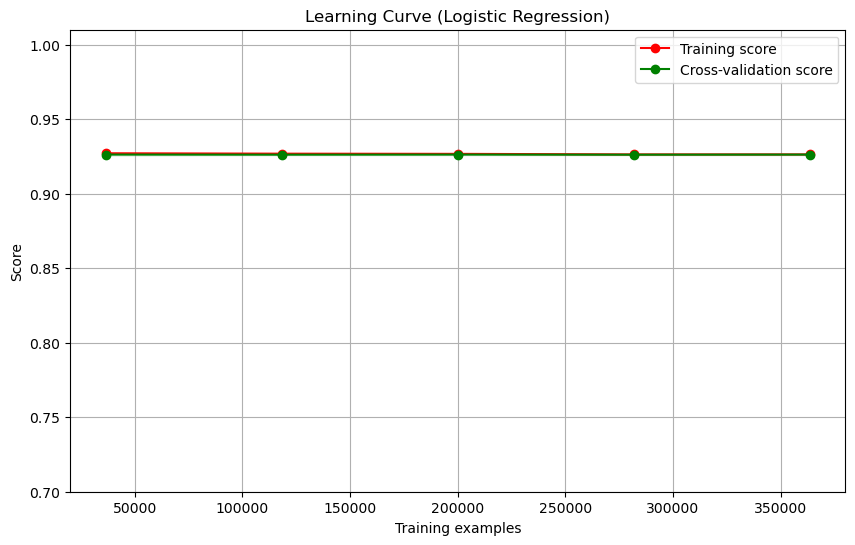

In [27]:
train_sizes, train_scores, test_scores = learning_curve(
    lr_gscv_drop.best_estimator_, X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (Logistic Regression)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.7, 1.01)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [28]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     24373
           1       0.96      0.97      0.97     87290
           2       0.81      0.78      0.79     24717

    accuracy                           0.93    136380
   macro avg       0.89      0.89      0.89    136380
weighted avg       0.93      0.93      0.93    136380



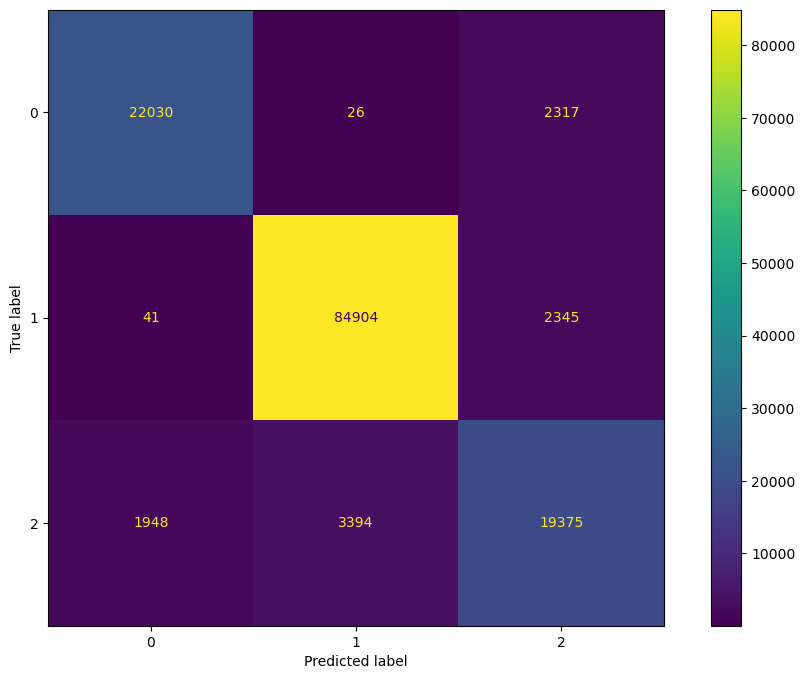

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

## Decision Trees

In [39]:
dt = DecisionTreeClassifier()

params = {
    'max_depth': [None, 2, 4, 8, 10],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

dt_gscv_drop= GridSearchCV(estimator=dt, param_grid=params, cv=3, verbose=3)
dt_gscv_drop.fit(X_train, y_train)

Fitting 3 folds for each of 160 candidates, totalling 480 fits


Again, GridSearchCV is used to get the best decision tree model using the parameters specified in the 'params' dictionary.

In [ ]:
pickle.dump(dt_gscv_drop, open('dt_gscv_drop.pkl', 'wb'))

Saving the model into a pickle file so that we don't need to train it again if the kernel was shut down.

In [27]:
dt_gscv_drop = pickle.load(open('dt_gscv_drop.pkl', 'rb'))

In [28]:
dt_gscv_drop.best_estimator_, dt_gscv_drop.best_params_, dt_gscv_drop.best_score_

(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2,
                        min_samples_split=4),
 {'criterion': 'entropy',
  'max_depth': None,
  'min_samples_leaf': 2,
  'min_samples_split': 4},
 0.9972173284258014)

Best model, parameters, and score

In [29]:
train_time_dropped.append(dt_gscv_drop.refit_time_)
train_accuracies_dropped.append(dt_gscv_drop.best_score_)
t_start = time.time()
y_preds = dt_gscv_drop.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time_dropped.append(total_time)

In [30]:
pred_score = accuracy_score(y_test, y_preds)
test_accuracies_dropped.append(pred_score)

In [31]:
dt_cv_results = dt_gscv_drop.cv_results_
dt_cv_results['mean_test_score']

array([0.99572517, 0.99586632, 0.99584616, 0.99592681, 0.99596898,
       0.99591948, 0.99594331, 0.99591398, 0.99596164, 0.99594881,
       0.99595614, 0.99597814, 0.99532555, 0.99531639, 0.99533838,
       0.99530905, 0.88189045, 0.88189045, 0.88189045, 0.88189045,
       0.88189045, 0.88189045, 0.88189045, 0.88189045, 0.88189045,
       0.88189045, 0.88189045, 0.88189045, 0.88189045, 0.88189045,
       0.88189045, 0.88189045, 0.91935386, 0.91935753, 0.9193557 ,
       0.91935386, 0.91935753, 0.9193557 , 0.91935753, 0.91935386,
       0.9193557 , 0.91935386, 0.91935753, 0.91935386, 0.91935386,
       0.91935753, 0.91935753, 0.9193557 , 0.96577571, 0.96579221,
       0.96577938, 0.96577938, 0.96578854, 0.96580504, 0.96581604,
       0.96580687, 0.96579588, 0.96580504, 0.96580321, 0.96580137,
       0.96577571, 0.96577571, 0.96578121, 0.96577938, 0.98112073,
       0.9811244 , 0.98112073, 0.98114273, 0.98120139, 0.98119956,
       0.98119772, 0.98120689, 0.98124905, 0.98124172, 0.98125

Appending the results into the lists I initiated at the start for later comparisons.

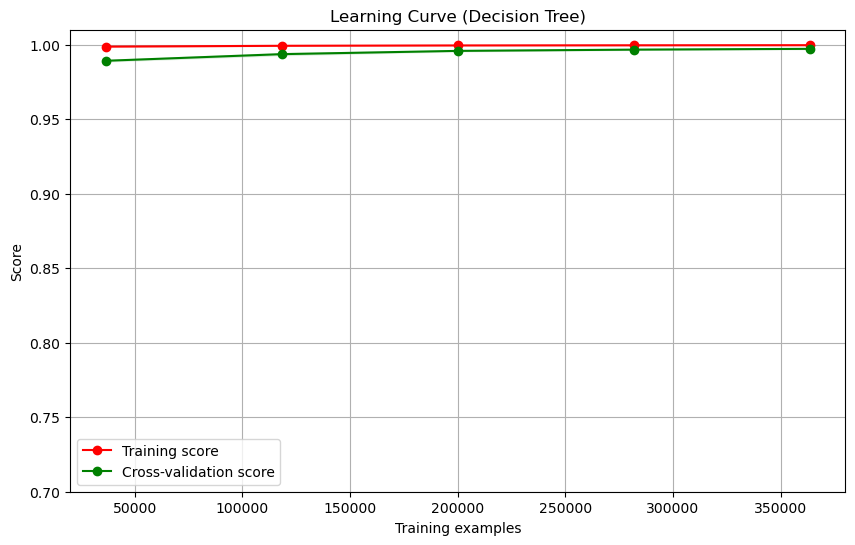

In [35]:
train_sizes, train_scores, test_scores = learning_curve(
    dt_gscv_drop.best_estimator_, X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (Decision Tree)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.7, 1.01)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [32]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24373
           1       1.00      1.00      1.00     87290
           2       0.99      0.99      0.99     24717

    accuracy                           1.00    136380
   macro avg       1.00      1.00      1.00    136380
weighted avg       1.00      1.00      1.00    136380



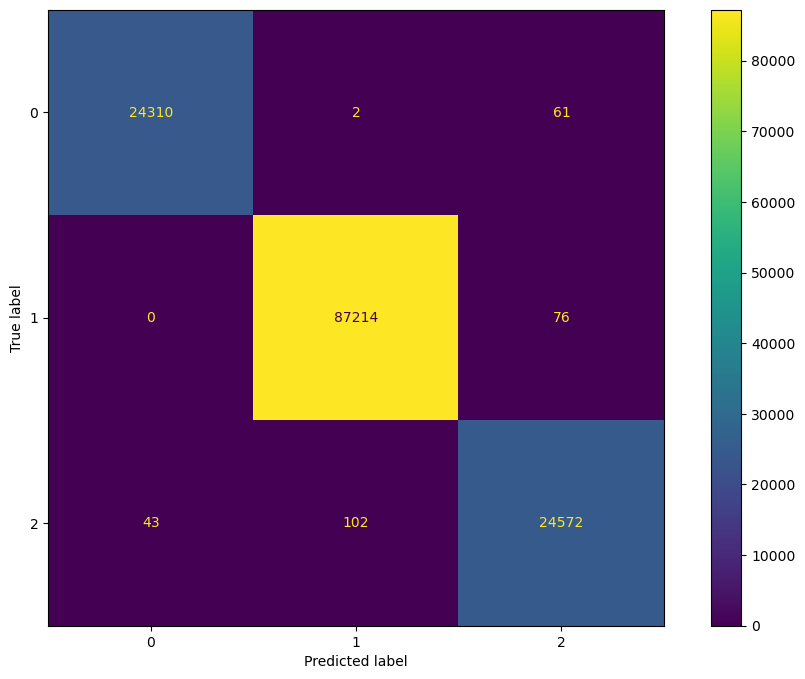

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

## Random Forest

In [ ]:
rf = RandomForestClassifier()

params = {
    'n_estimators': [2, 4, 8, 16, 32, 100, 200],
    'max_depth': [None, 2],
    'min_samples_split': [6, 8],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

rf_gscv_drop = GridSearchCV(estimator=rf, param_grid=params, cv=3, verbose=3)
rf_gscv_drop.fit(X_train, y_train)

GridSearchCV is used to get the best random forest model using the parameters specified in the 'params' dictionary.

In [ ]:
pickle.dump(rf_gscv_drop, open('rf_gscv_drop.pkl', 'wb'))

Saving the model into a pickle file so that we don't need to train it again if the kernel was shut down.

In [33]:
rf_gscv_drop = pickle.load(open('rf_gscv_drop.pkl', 'rb'))

In [34]:
rf_gscv_drop.best_estimator_, rf_gscv_drop.best_params_, rf_gscv_drop.best_score_

(RandomForestClassifier(criterion='entropy', min_samples_split=6,
                        n_estimators=200),
 {'criterion': 'entropy',
  'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 200},
 0.9833699640067705)

Best model, parameters, and score

In [35]:
train_time_dropped.append(rf_gscv_drop.refit_time_)
train_accuracies_dropped.append(rf_gscv_drop.best_score_)
t_start = time.time()
y_preds = rf_gscv_drop.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time_dropped.append(total_time)

In [36]:
pred_score = accuracy_score(y_test, y_preds)
test_accuracies_dropped.append(pred_score)

In [37]:
rf_cv_results = rf_gscv_drop.cv_results_
rf_cv_results['mean_test_score']

array([0.95232247, 0.97032367, 0.97592201, 0.97730418, 0.98121972,
       0.98216377, 0.98259089, 0.95233714, 0.97005604, 0.97505678,
       0.97752599, 0.98101074, 0.98180448, 0.98260189, 0.95468719,
       0.97095976, 0.97629231, 0.97816025, 0.98152402, 0.98143786,
       0.98159367, 0.95683927, 0.96908815, 0.97587252, 0.97973673,
       0.98159184, 0.98147635, 0.98149469, 0.95480085, 0.96834574,
       0.97389642, 0.97811442, 0.97921429, 0.98073578, 0.98011802,
       0.96146789, 0.96507912, 0.97352063, 0.97636379, 0.97910247,
       0.98000986, 0.98035265, 0.74904457, 0.7147413 , 0.75625608,
       0.80896171, 0.76193304, 0.77558987, 0.7765614 , 0.73131461,
       0.76246479, 0.74790049, 0.82096681, 0.79990244, 0.77596567,
       0.78810636, 0.78286747, 0.79528305, 0.79230952, 0.80616807,
       0.7755659 , 0.78852066, 0.78492409, 0.82042793, 0.7948979 ,
       0.81315221, 0.79860841, 0.78665083, 0.78134215, 0.77604263,
       0.80460453, 0.73573235, 0.79694193, 0.77958038, 0.80435

Appending the results into the lists I initiated at the start for later comparisons.

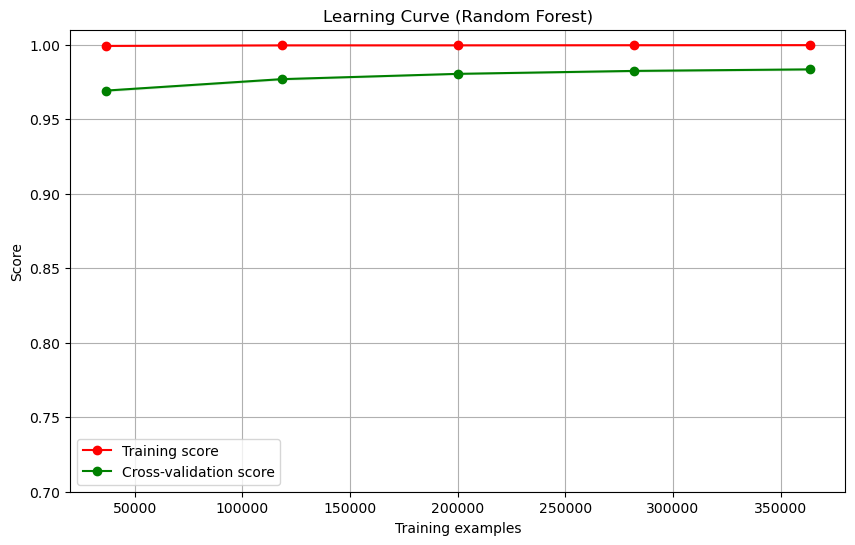

In [43]:
train_sizes, train_scores, test_scores = learning_curve(
    rf_gscv_drop.best_estimator_, X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (Random Forest)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.7, 1.01)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [44]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     24373
           1       0.99      0.99      0.99     87290
           2       0.96      0.96      0.96     24717

    accuracy                           0.99    136380
   macro avg       0.98      0.98      0.98    136380
weighted avg       0.99      0.99      0.99    136380



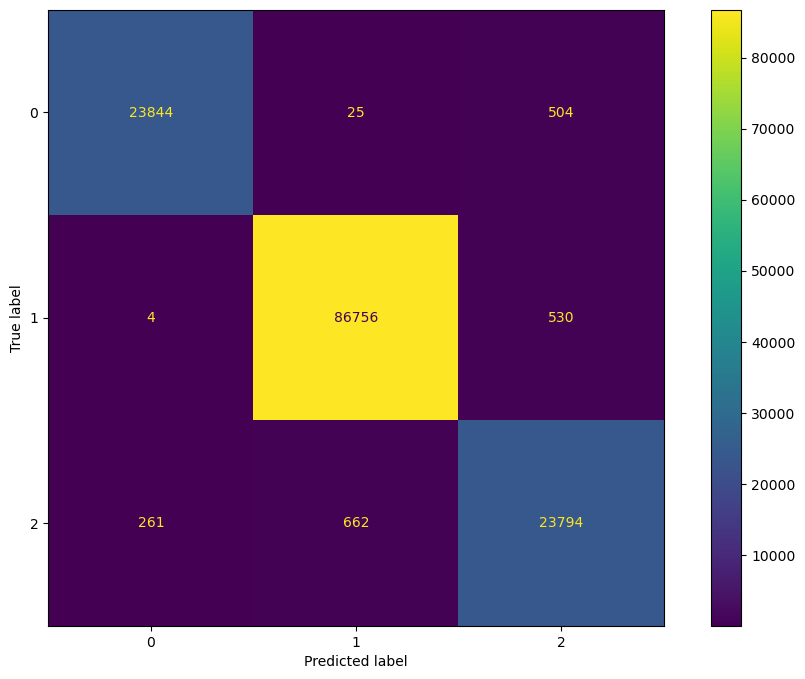

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

## Naive Bayes

In [ ]:
nb = GaussianNB()

params = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nb_gscv_drop = GridSearchCV(estimator=nb, param_grid=params, cv=3, verbose=3, n_jobs=-1)
nb_gscv_drop.fit(X_train, y_train)

The GridSearchCV doesn't output anything using the GaussianNB classifier however the trainig time didn't take long and it outputted the needed results. One reason for not outputting anything I found is that there is no parameter tuning for the GaussianNB.

'var_smoothing' is a stability calculation to widen (or smooth) the curve and therefore account for more samples that are further away from the distribution mean. 

In [ ]:
pickle.dump(nb_gscv_drop, open('nb_gscv_drop.pkl', 'wb'))

Saving the model into a pickle file so that we don't need to train it again if the kernel was shut down.

In [38]:
nb_gscv_drop = pickle.load(open('nb_gscv_drop.pkl', 'rb'))

In [39]:
nb_gscv_drop.best_estimator_, nb_gscv_drop.best_params_, nb_gscv_drop.best_score_

(GaussianNB(var_smoothing=0.0004328761281083057),
 {'var_smoothing': 0.0004328761281083057},
 0.7542578510392617)

Best model, parameters, and score

In [40]:
train_time_dropped.append(nb_gscv_drop.refit_time_)
train_accuracies_dropped.append(nb_gscv_drop.best_score_)
t_start = time.time()
y_preds = nb_gscv_drop.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time_dropped.append(total_time)

In [41]:
pred_score = accuracy_score(y_test, y_preds)
test_accuracies_dropped.append(pred_score)

In [42]:
nb_cv_results = rf_gscv_drop.cv_results_
nb_cv_results['mean_test_score']

array([0.95232247, 0.97032367, 0.97592201, 0.97730418, 0.98121972,
       0.98216377, 0.98259089, 0.95233714, 0.97005604, 0.97505678,
       0.97752599, 0.98101074, 0.98180448, 0.98260189, 0.95468719,
       0.97095976, 0.97629231, 0.97816025, 0.98152402, 0.98143786,
       0.98159367, 0.95683927, 0.96908815, 0.97587252, 0.97973673,
       0.98159184, 0.98147635, 0.98149469, 0.95480085, 0.96834574,
       0.97389642, 0.97811442, 0.97921429, 0.98073578, 0.98011802,
       0.96146789, 0.96507912, 0.97352063, 0.97636379, 0.97910247,
       0.98000986, 0.98035265, 0.74904457, 0.7147413 , 0.75625608,
       0.80896171, 0.76193304, 0.77558987, 0.7765614 , 0.73131461,
       0.76246479, 0.74790049, 0.82096681, 0.79990244, 0.77596567,
       0.78810636, 0.78286747, 0.79528305, 0.79230952, 0.80616807,
       0.7755659 , 0.78852066, 0.78492409, 0.82042793, 0.7948979 ,
       0.81315221, 0.79860841, 0.78665083, 0.78134215, 0.77604263,
       0.80460453, 0.73573235, 0.79694193, 0.77958038, 0.80435

Appending the results into the lists I initiated at the start for later comparisons.

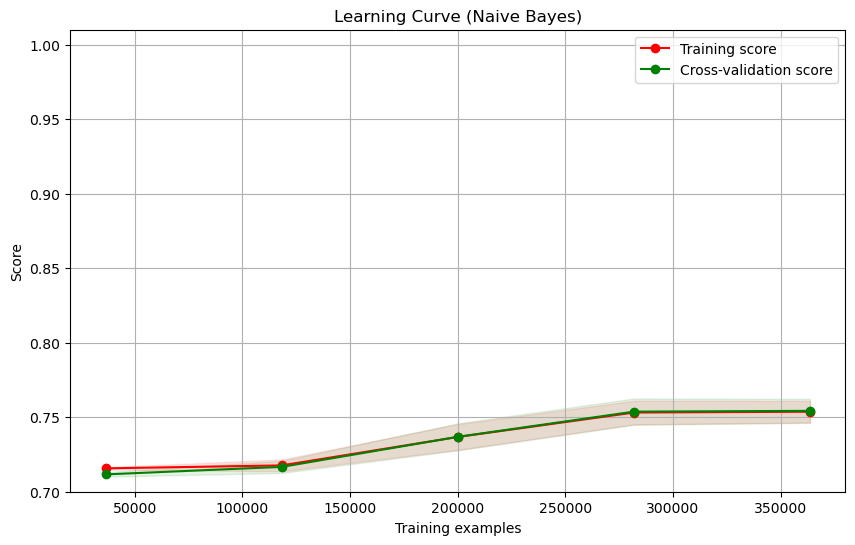

In [51]:
train_sizes, train_scores, test_scores = learning_curve(
    nb_gscv_drop.best_estimator_, X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (Naive Bayes)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.7, 1.01)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [52]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.62      0.26      0.36     24373
           1       0.95      0.89      0.92     87290
           2       0.43      0.76      0.55     24717

    accuracy                           0.76    136380
   macro avg       0.66      0.64      0.61    136380
weighted avg       0.80      0.76      0.75    136380



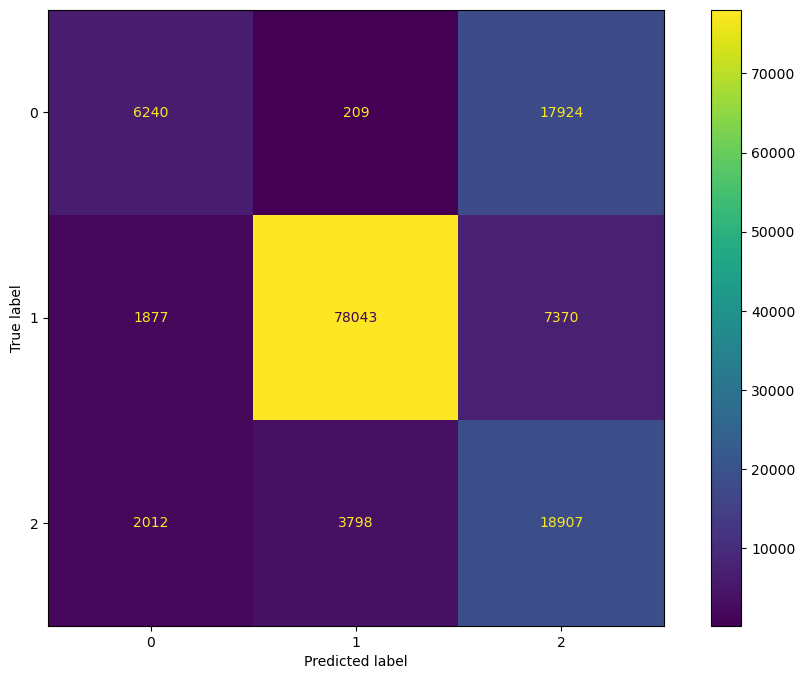

In [53]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

### KNN

In [3]:
knn = KNeighborsClassifier()

# optimal_k = round(np.sqrt(X_train.shape[0])/2)
# optimal_k2 = round(np.sqrt(X_train.shape[0]))
#As it takes sooo much time to run and the kernal shut down therefore we will us the optimal K's found when trying with the undropped data to try and speed up the running of the model

optimal_k = 369
optimal_k2 = 739

n_neighbors = [7, optimal_k, optimal_k2]
p = [1]

params = {
    'n_neighbors': n_neighbors,
    'p': p
}

knn_gscv_drop = GridSearchCV(estimator=knn, param_grid=params, cv=3, verbose=3)
knn_gscv_drop.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END ................n_neighbors=7, p=1;, score=0.923 total time= 8.1min
[CV 2/3] END ................n_neighbors=7, p=1;, score=0.924 total time= 8.1min
[CV 3/3] END ................n_neighbors=7, p=1;, score=0.923 total time= 8.1min
[CV 1/3] END ..............n_neighbors=369, p=1;, score=0.878 total time= 8.0min
[CV 2/3] END ..............n_neighbors=369, p=1;, score=0.880 total time= 8.1min
[CV 3/3] END ..............n_neighbors=369, p=1;, score=0.878 total time= 8.0min
[CV 1/3] END ..............n_neighbors=739, p=1;, score=0.863 total time= 8.3min
[CV 2/3] END ..............n_neighbors=739, p=1;, score=0.864 total time= 8.3min
[CV 3/3] END ..............n_neighbors=739, p=1;, score=0.862 total time= 8.3min


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [7, 369, 739], 'p': [1]}, verbose=3)

Used the optimal values of k as well as the best value of k (7) from the original dataset. Because it takes too much time time to run the KNN.

In [4]:
pickle.dump(knn_gscv_drop, open('knn_gscv_drop.pkl', 'wb'))

Saving the model into a pickle file so that we don't need to train it again if the kernel was shut down.

In [43]:
knn_gscv_drop = pickle.load(open('knn_gscv_drop.pkl', 'rb'))

c:\anacon\envs\data_eng\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\anacon\envs\data_eng\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [44]:
knn_gscv_drop.best_estimator_, knn_gscv_drop.best_params_, knn_gscv_drop.best_score_

(KNeighborsClassifier(n_neighbors=7, p=1),
 {'n_neighbors': 7, 'p': 1},
 0.9234912064504015)

Best model, parameters, and score

In [45]:
train_time_dropped.append(knn_gscv_drop.refit_time_)
train_accuracies_dropped.append(knn_gscv_drop.best_score_)
t_start = time.time()
y_preds = knn_gscv_drop.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time_dropped.append(total_time)

c:\anacon\envs\data_eng\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\anacon\envs\data_eng\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


In [46]:
pred_score = accuracy_score(y_test, y_preds)
test_accuracies_dropped.append(pred_score)

In [47]:
knn_cv_results = rf_gscv_drop.cv_results_
knn_cv_results['mean_test_score']

array([0.95232247, 0.97032367, 0.97592201, 0.97730418, 0.98121972,
       0.98216377, 0.98259089, 0.95233714, 0.97005604, 0.97505678,
       0.97752599, 0.98101074, 0.98180448, 0.98260189, 0.95468719,
       0.97095976, 0.97629231, 0.97816025, 0.98152402, 0.98143786,
       0.98159367, 0.95683927, 0.96908815, 0.97587252, 0.97973673,
       0.98159184, 0.98147635, 0.98149469, 0.95480085, 0.96834574,
       0.97389642, 0.97811442, 0.97921429, 0.98073578, 0.98011802,
       0.96146789, 0.96507912, 0.97352063, 0.97636379, 0.97910247,
       0.98000986, 0.98035265, 0.74904457, 0.7147413 , 0.75625608,
       0.80896171, 0.76193304, 0.77558987, 0.7765614 , 0.73131461,
       0.76246479, 0.74790049, 0.82096681, 0.79990244, 0.77596567,
       0.78810636, 0.78286747, 0.79528305, 0.79230952, 0.80616807,
       0.7755659 , 0.78852066, 0.78492409, 0.82042793, 0.7948979 ,
       0.81315221, 0.79860841, 0.78665083, 0.78134215, 0.77604263,
       0.80460453, 0.73573235, 0.79694193, 0.77958038, 0.80435

Appending the results into the lists I initiated at the start for later comparisons.

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    knn_gscv_drop.best_estimator_, X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (Decision Tree)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.7, 1.01)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

The running of the above cell will take more then 3500Minutes therefore not worth it to run

In [48]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     24373
           1       0.95      0.98      0.96     87290
           2       0.83      0.77      0.80     24717

    accuracy                           0.93    136380
   macro avg       0.91      0.89      0.90    136380
weighted avg       0.93      0.93      0.93    136380



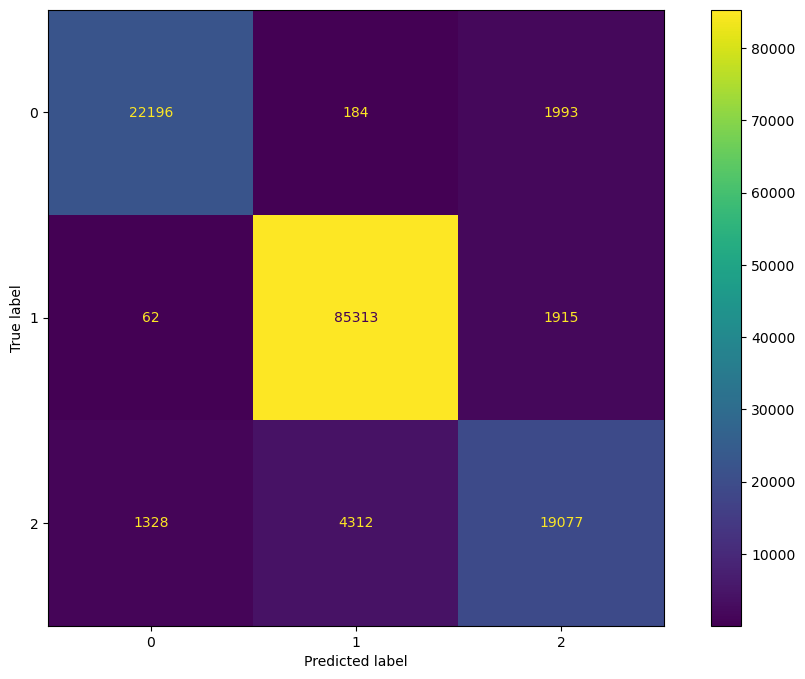

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

# Comparison

In [50]:
data_dict = {'train_accuracies': train_accuracies_dropped, 'test_accuracies': test_accuracies_dropped, 'train_time (sec)': train_time_dropped, 'prediction_time (sec)': prediction_time_dropped}
compare_df = pd.DataFrame({col: np.nan for col in data_dict.keys()}, index=models_dropped)

for col, data in data_dict.items():
    compare_df.loc[compare_df.index[:len(data)], col] = data

To compare also between the full data and the dropped data 

train_accuracies	test_accuracies	train_time (sec)	prediction_time (sec)
KNN	0.957345	0.960060	0.152227	767.253599
Logistic Regression	0.991302	0.991634	8.737298	0.034194
Decision Trees	0.996145	0.996840	10.686125	0.037731
Random Forest	0.994724	0.995212	317.445117	4.796870
Naive Bayes	0.828395	0.827225	0.377641	0.359181

In [51]:
compare_df

,train_accuracies,test_accuracies,train_time (sec),prediction_time (sec)
Logistic Regression,0.926226,0.926155,17.817131,0.030912
Decision Trees,0.997217,0.997918,8.090701,0.032801
Random Forest,0.983370,0.985438,420.051004,6.302768
Naive Bayes,0.754258,0.756636,0.741530,0.176044
KNN,0.923491,0.928186,0.104008,1260.428676


After removing all monetary features, we retrained and tested our models to assess their robustness without relying on these highly informative attributes. As expected, the overall accuracies declined slightly, but the models still demonstrated very high performance. Logistic regression, decision trees, and random forest remained the top performers, maintaining high accuracies for both training and testing phases. However the KNN isnt too far behing the Logistic regression by only a 0.003% difference. The Naive Bayes, while still the least accurate, showed a marginal improvement in relative performance compared to KNN. The differences among the top three models were minimal: decision trees outperformed random forest by ~0.1%, however the logistic regression decreased from the full dataset to the dropped data set to 92% and trailed off behind the decision trees and the random forest by by ~6%. Notably, decision trees continued to exhibit the second shortest training time among these models at 8.09 seconds and the second lowest prediction time at 0.033 seconds, maintaining their status as the most efficient option. 

These results indicate that even without the monetary features, decision trees remain the best option for this dataset due to their high accuracy and efficiency. This exercise underscores the robustness of our models and highlights the importance of comprehensive feature engineering in achieving optimal performance.

Finally, through this project, we have gained invaluable insights into the strengths and limitations of various machine learning models, particularly in handling detailed and comprehensive datasets. We are deeply grateful for this project and course (even tho our laptops arent), which have been instrumental in our learning journey. Thank you DR.maggie for this enriching opportunity and for helping us develop skills that will be crucial in our future endeavors.

Team:-
Mahmoud Yasser 49-5012
mahmoud Elnakib 49-8948
Nour Hosny 49-3501